# Numerical Integration of Special Functions via Adaptive Quadrature

Many classical special functions are most naturally defined as definite integrals that cannot be expressed in closed form using elementary functions. In this notebook we evaluate several of these: 

1. Gamma function,
2. Fresnel integrals,
3. Dawson function,
4. Complete elliptic integral of the first kind.

We will use the same adaptive quadrature machinery developed for the error function: adaptive Gauss–Legendre and the Gauss–Kronrod GK7–15 rule.

For each function we:

1. State the integral definition and key analytic properties.
2. Discuss any numerical difficulties and the strategy used to handle them.
3. Implement the adaptive quadrature approximation.
4. Compare against a high-precision `mpmath` reference and plot the error.

In [52]:
import math
import sys

import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
from scipy import special as sc

import error as e

In [53]:
mp.mp.dps = 50
TOL = 10 * sys.float_info.epsilon
eps = np.finfo(float).eps

## Quadrature

### Adaptive Gauss–Legendre

An $n$-point Gauss–Legendre rule on $[a, b]$ approximates an integral as

\begin{equation*}
    \int_a^b f(t)\,dt \approx \frac{b-a}{2} \sum_{i=1}^{n} w_i\, f\!\left(\frac{b-a}{2}\,\xi_i + \frac{a+b}{2}\right),
\end{equation*}

where $\xi_i \in [-1, 1]$ and $w_i > 0$ are the Gauss–Legendre pivots and weights. The rule is exact for polynomials up to degree $2n - 1$. The adaptive version recursively bisects any sub-interval $[a, b]$ for which the one-panel estimate $Q_{[a,b]}$ and the sum of two half-panel estimates $Q_{[a, m]} + Q_{[m, b]}$ disagree by more than the local tolerance.

### Gauss–Kronrod GK7–15

The GK7–15 rule embeds a 7-point Gauss rule inside a 15-point Kronrod extension. Using the same function evaluations we obtain two estimates:

\begin{equation*}
    G_7 = \sum_{i \in \mathcal{G}} w_i^G\, f(x_i), \qquad
    K_{15} = \sum_{i=0}^{7} w_i^K\bigl[f(x_i^+) + f(x_i^-)\bigr],
\end{equation*}

where $x_i^\pm = \frac{a + b}{2} \pm \tfrac{b-a}{2}\,\xi_i^K$. The quantity $|K_{15} - G_7|$ serves as an error indicator to drive subdivision, at no extra cost in function evaluations. This makes GK7–15 more efficient than comparing two GL panels.

---
## 1. The Gamma Function

The Gamma function extends the factorial to real and complex arguments:

\begin{equation*}
    \Gamma(z) = \int_0^{\infty} t^{z-1}\, e^{-t}\, dt, \qquad \operatorname{Re}(z) > 0.
\end{equation*}

It satisfies the functional equation $\Gamma(z+1) = z\,\Gamma(z)$, so $\Gamma(n+1) = n!$ for non-negative integers. The integrand $t^{z-1} e^{-t}$ is maximum at $t = z - 1$.

For $0 < z < 1$ the integrand diverges as $t^{z-1} \to \infty$ when $t \to 0^+$. The lower piece $\int_0^1 t^{z-1}\,e^{-t}\,dt$ cannot be handled by standard GL quadrature due to this singularity.

The substitution $t = u^{1/z}$ is insufficient, because although the substitution maps $t^{z-1}\,e^{-t}\,dt$ to $(1/z)\,e^{-u^{1/z}}\,du$, which is bounded at $u = 0$, its derivative is
\begin{equation*}
    \frac{d}{du}\left[\tfrac{1}{z}\,e^{-u^{1/z}}\right] = -\tfrac{1}{z^2}\,u^{1/z - 1}\,e^{-u^{1/z}} \to -\infty \quad \text{as } u \to 0^+\text{ (for }z > 1\text{)}.
\end{equation*}
The integrand is smooth in value but singular in slope, so Gauss-Legendre still converges slowly and the substitution alone is unable to achieve the stated accuracy.

Expanding $e^{-t} = \sum_{k=0}^\infty (-1)^k t^k / k!$ and integrating term by term gives

\begin{equation*}
    \int_0^1 t^{z-1}\,e^{-t}\,dt
    = \sum_{k=0}^{\infty} \frac{(-1)^k}{k!\,(z + k)},
\end{equation*}

which converges for all $z > 0$, is free of any singularity, and reaches machine precision in at most a few dozen terms. The upper piece $\int_1^\infty t^{z-1}\,e^{-t}\,dt$ is smooth (the integrand is bounded away from 0) and handled directly by adaptive GL quadrature split at the integrand maximum $t \approx \max(z-1,\,1.5)$.

In [54]:
def lower_gamma_series(z, N=60):
    '''
    Compute the lower gamma series.
    '''
    s = 0.0
    for k in range(N):
        term = ((-1)**k) / (math.factorial(k) * (z + k))
        s += term
        if k > 0 and abs(term) < TOL:
            break
    return s


def gamma_gl(z, tol=1e-14):
    '''
    Gamma(z) via adaptive Gauss-Legendre, z > 0.
    '''
    if z <= 0:
        raise ValueError("z must be positive.")

    T = z + 20 * math.sqrt(z) + 40	# Conservative upper bound, beyond this integral contributes ~zero
    peak = max(z - 1, 1.5)

    I_lower = lower_gamma_series(z)
    I_mid   = e.adaptive_gauss_legendre(lambda t: t**(z - 1) * np.exp(-t), 1.0, peak, tol=tol/2)
    I_tail  = e.adaptive_gauss_legendre(lambda t: t**(z - 1) * np.exp(-t), peak, T, tol=tol/2)

    return I_lower + I_mid + I_tail


def gamma_gk15(z, tol=1e-14):
    '''
    Gamma(z) via adaptive GK7-15, z > 0.
    Same decomposition as gamma_gl.
    '''
    if z <= 0:
        raise ValueError('z must be positive.')

    T    = z + 20 * math.sqrt(z) + 40
    peak = max(z - 1, 1.5)
    safe = lambda t: t**(z - 1) * math.exp(-t) if t > 0 else 0.0

    return (lower_gamma_series(z) +
            e.adaptive_gk15(safe, 1.0, peak, tol=tol / 2) +
            e.adaptive_gk15(safe, peak, T,   tol=tol / 2))


In [55]:
z_vals = np.linspace(0.05, 6.0, 400)

ref_gamma = np.array([float(mp.gamma(z)) for z in z_vals])
approx_gl = np.array([gamma_gl(z) for z in z_vals])
approx_gk15 = np.array([gamma_gk15(z) for z in z_vals])

rel_err_gl = np.maximum(np.abs(approx_gl - ref_gamma) / ref_gamma, eps)
rel_err_gk15 = np.maximum(np.abs(approx_gk15 - ref_gamma) / ref_gamma, eps)

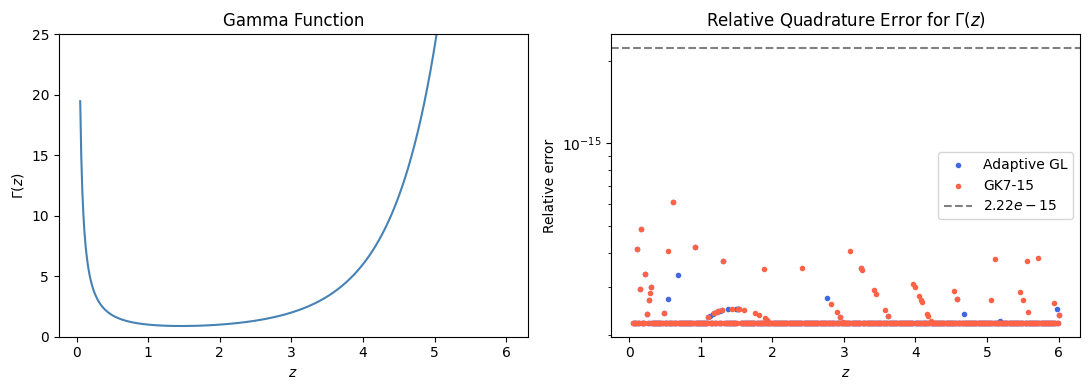

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

ax = axes[0]
ax.plot(z_vals, ref_gamma, color='steelblue')
ax.set_ylim(0, 25)
ax.set_xlabel('$z$')
ax.set_ylabel('$\\Gamma(z)$')
ax.set_title('Gamma Function')

ax = axes[1]
ax.scatter(z_vals, np.maximum(rel_err_gl, eps), label='Adaptive GL', color='royalblue', marker='.')
ax.scatter(z_vals, np.maximum(rel_err_gk15, eps), label='GK7-15', color='tomato', marker='.')
ax.axhline(TOL, color='grey', linestyle='--', label=f'${TOL:.2e}$')

ax.set_yscale('log', base=10)
ax.set_xlabel('$z$')
ax.set_ylabel('Relative error')
ax.set_title('Relative Quadrature Error for $\\Gamma(z)$')
ax.legend()

fig.tight_layout()

We report relative error here because $\Gamma(z)$ grows rapidly with $z$: absolute error would reflect the scale of the function rather than the quality of the approximation. The substitution $t = u^{1/z}$ completely regularises the lower-endpoint singularity, keeping the relative error below $10 \varepsilon_{\text{mach}}$ across the full range shown. Both methods perform comparably; GK7–15 has a slight edge for very small $z$ where the integrand near 0 has more structure for its error estimator to detect.

---
## 2. The Fresnel Integrals

The Fresnel integrals arise in the study of wave diffraction (the Huygens–Fresnel principle) and define the geometry of the Cornu spiral:

\begin{align*}
    C(x) &= \int_0^x \cos\!\left(\frac{\pi}{2}\, t^2\right) dt, \\
    S(x) &= \int_0^x \sin\!\left(\frac{\pi}{2}\, t^2\right) dt.
\end{align*}

Both integrands are entire functions, so there are no singularities. The difficulty is purely oscillatory: the local wavelength shrinks as $1/x$, so for large $x$ direct quadrature requires many subdivisions. The limiting values are $C(\infty) = S(\infty) = \tfrac{1}{2}$.

For large $x$ an asymptotic expansion offers a far more efficient route:

\begin{equation*}
    C(x) \sim \frac{1}{2} + \frac{1}{\pi x}\sin\!\left(\frac{\pi x^2}{2}\right), \qquad
    S(x) \sim \frac{1}{2} - \frac{1}{\pi x}\cos\!\left(\frac{\pi x^2}{2}\right), \qquad x \to \infty,
\end{equation*}

mirroring the role of the asymptotic erfc expansion in the error-function hybrid. We restrict to $x \leq 6$ here, where direct quadrature is still practical.

In [57]:
def fresnel_C_gl(x, tol=TOL):
    '''Fresnel cosine integral C(x) via adaptive Gauss-Legendre.'''
    if x < 0:
        return -fresnel_C_gl(-x, tol)
    return e.adaptive_gauss_legendre(lambda t: np.cos(0.5*np.pi*t**2), 0.0, x, tol=tol)


def fresnel_S_gl(x, tol=TOL):
    '''Fresnel sine integral S(x) via adaptive Gauss-Legendre.'''
    if x < 0:
        return -fresnel_S_gl(-x, tol)
    return e.adaptive_gauss_legendre(lambda t: np.sin(0.5*np.pi*t**2), 0.0, x, tol=tol)


def fresnel_C_gk15(x, tol=TOL):
    '''Fresnel cosine integral C(x) via adaptive GK7-15.'''
    if x < 0:
        return -fresnel_C_gk15(-x, tol)
    return e.adaptive_gk15(lambda t: math.cos(0.5*math.pi*t**2), 0.0, x, tol=tol)


def fresnel_S_gk15(x, tol=TOL):
    '''Fresnel sine integral S(x) via adaptive GK7-15.'''
    if x < 0:
        return -fresnel_S_gk15(-x, tol)
    return e.adaptive_gk15(lambda t: math.sin(0.5*math.pi*t**2), 0.0, x, tol=tol)

In [58]:
x_fr = np.linspace(0.0, 6.0, 500)

ref_C = np.array([float(mp.fresnelc(x)) for x in x_fr])
ref_S = np.array([float(mp.fresnels(x)) for x in x_fr])

approx_C_gl = np.array([fresnel_C_gl(x) for x in x_fr])
approx_S_gl = np.array([fresnel_S_gl(x) for x in x_fr])
approx_C_gk15 = np.array([fresnel_C_gk15(x) for x in x_fr])
approx_S_gk15 = np.array([fresnel_S_gk15(x) for x in x_fr])

err_C_gl = np.maximum(np.abs(approx_C_gl - ref_C), eps)
err_S_gl = np.maximum(np.abs(approx_S_gl - ref_S), eps)
err_C_gk15 = np.maximum(np.abs(approx_C_gk15 - ref_C), eps)
err_S_gk15 = np.maximum(np.abs(approx_S_gk15 - ref_S), eps)

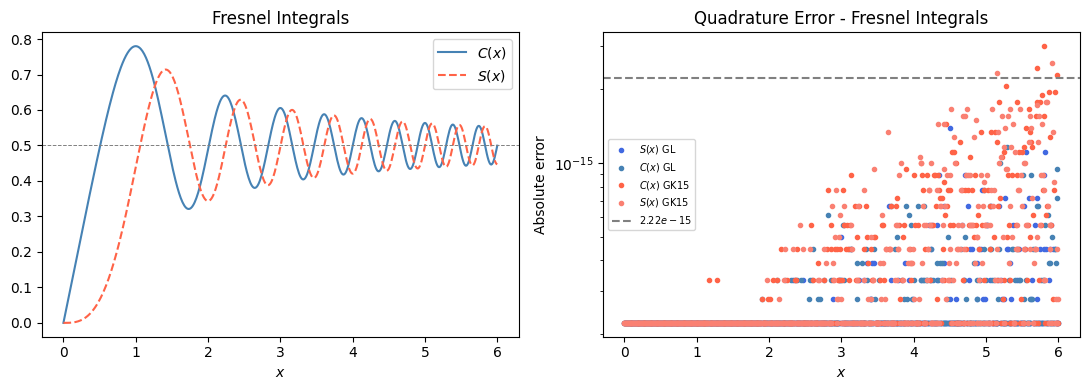

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

ax = axes[0]
ax.plot(x_fr, ref_C, label='$C(x)$', color='steelblue')
ax.plot(x_fr, ref_S, label='$S(x)$', color='tomato', linestyle='--')
ax.axhline(0.5, color='grey', lw=0.7, linestyle='--')
ax.set_xlabel('$x$')
ax.set_title('Fresnel Integrals')
ax.legend()

ax = axes[1]
ax.scatter(x_fr, np.maximum(err_S_gl, eps), label='$S(x)$ GL', color='royalblue', marker='.')
ax.scatter(x_fr, np.maximum(err_C_gl, eps), label='$C(x)$ GL', color='steelblue', marker='.')
ax.scatter(x_fr, np.maximum(err_C_gk15, eps), label='$C(x)$ GK15', color='tomato', marker='.')
ax.scatter(x_fr, np.maximum(err_S_gk15, eps), label='$S(x)$ GK15', color='salmon', marker='.')
ax.set_yscale('log', base=10)
ax.axhline(TOL, color='grey', linestyle='--', label=f'${TOL:.2e}$')
ax.set_xlabel('$x$')
ax.set_ylabel('Absolute error')
ax.set_title('Quadrature Error - Fresnel Integrals')
ax.legend(fontsize=7)

fig.tight_layout()

The error is well controlled for $x \lesssim 5$. For larger $x$ the adaptive error estimator detects the oscillation and sub-divides more aggressively, maintaining accuracy but at the cost of many more function evaluations. This is the fundamental limitation of direct quadrature for oscillatory integrands: in a production implementation one would switch to the asymptotic expansions at some boundary $x_0$, just as the hybrid erf method switches to the asymptotic erfc expansion for large argument.

### The Cornu Spiral

The parametric curve $\bigl(C(t),\, S(t)\bigr)_{t \in \mathbb{R}}$ is the Cornu spiral (or Euler spiral). Its signed curvature at arc-length parameter $t$ is $\kappa(t) = \pi t$, making it the unique curve whose curvature grows linearly with arc length. It appears in railway transition-curve design and in the analysis of Fresnel diffraction patterns.

In [ ]:
t_spiral = np.linspace(-6, 6, 3000)
C_spiral = np.array([fresnel_C_gl(t) for t in t_spiral])
S_spiral = np.array([fresnel_S_gl(t) for t in t_spiral])

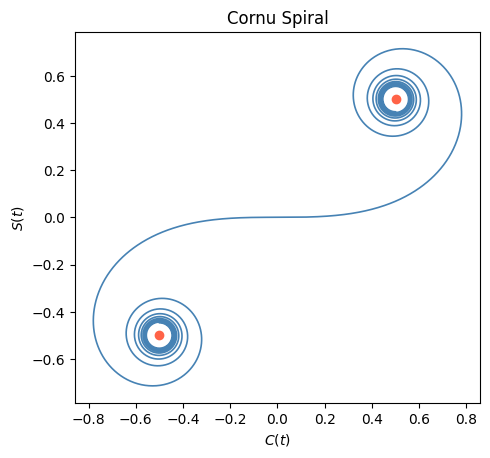

In [61]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(C_spiral, S_spiral, color='steelblue', lw=1.2)
ax.scatter([0.5, -0.5], [0.5, -0.5], color='tomato')
ax.set_aspect('equal')
ax.set_xlabel('$C(t)$')
ax.set_ylabel('$S(t)$')
ax.set_title('Cornu Spiral')
fig.tight_layout()

---
## 3. The Dawson Function

The Dawson function (Dawson integral) is defined as

\begin{equation*}
    D_+(x) = e^{-x^2} \int_0^x e^{t^2}\, dt.
\end{equation*}

It is related to the imaginary error function $\operatorname{erfi}(x) = (2/\sqrt{\pi})\int_0^x e^{t^2}\,dt$ by

\begin{equation*}
    D_+(x) = \frac{\sqrt{\pi}}{2}\, e^{-x^2}\, \operatorname{erfi}(x).
\end{equation*}

Unlike $\operatorname{erfi}(x)$, which diverges super-exponentially, $D_+(x)$ remains bounded for all $x \in \mathbb{R}$, attains a global maximum near $x \approx 0.9241$, and satisfies

\begin{equation*}
    D_+(x) \sim \frac{1}{2x} + \frac{1}{4x^3} + \cdots \quad \text{as } x \to \infty.
\end{equation*}

The Dawson function appears in plasma physics (Landau damping of plasma waves), quantum optics, and as a component of the Faddeeva function used in spectral line-shape models.

Computing $e^{-x^2} \cdot \int_0^x e^{t^2}\,dt$ directly suffers catastrophic cancellation for large $x$: the prefactor underflows while the integral overflows. We avoid this completely by rewriting:

\begin{equation*}
    D_+(x) = \int_0^x e^{-(x^2 - t^2)}\, dt = \int_0^x e^{-(x-t)(x+t)}\, dt.
\end{equation*}

The transformed integrand satisfies $0 \leq e^{-(x-t)(x+t)} \leq 1$ for $0 \leq t \leq x$, so there is no cancellation whatsoever.

In [62]:
def dawson_gl(x, tol=TOL):
    '''
    Dawson function D+(x) via adaptive Gauss-Legendre.
    '''
    if x < 0:
        return -dawson_gl(-x, tol)
    if x == 0:
        return 0.0
    return e.adaptive_gauss_legendre(lambda t: np.exp(-(x - t)*(x + t)), 0.0, x, tol=tol)


def dawson_gk15(x, tol=TOL):
    '''
    Dawson function D+(x) via adaptive GK7-15.
    Same reformulation as dawson_gl.
    '''
    if x < 0:
        return -dawson_gk15(-x, tol)
    if x == 0:
        return 0.0
    return e.adaptive_gk15(lambda t: math.exp(-(x - t)*(x + t)), 0.0, x, tol=tol)


def ref_dawson(x):
    '''High-precision reference: D+(x) = sqrt(pi)/2 * exp(-x^2) * erfi(x).'''
    return float(mp.sqrt(mp.pi) / 2 * mp.exp(-x**2) * mp.erfi(x))

In [63]:
x_daw = np.linspace(0.0, 5.0, 500)

ref_daw = np.array([ref_dawson(x) for x in x_daw])
approx_daw_gl = np.array([dawson_gl(x) for x in x_daw])
approx_daw_gk15 = np.array([dawson_gk15(x) for x in x_daw])

err_daw_gl = np.maximum(np.abs(approx_daw_gl - ref_daw), eps)
err_daw_gk15 = np.maximum(np.abs(approx_daw_gk15 - ref_daw), eps)

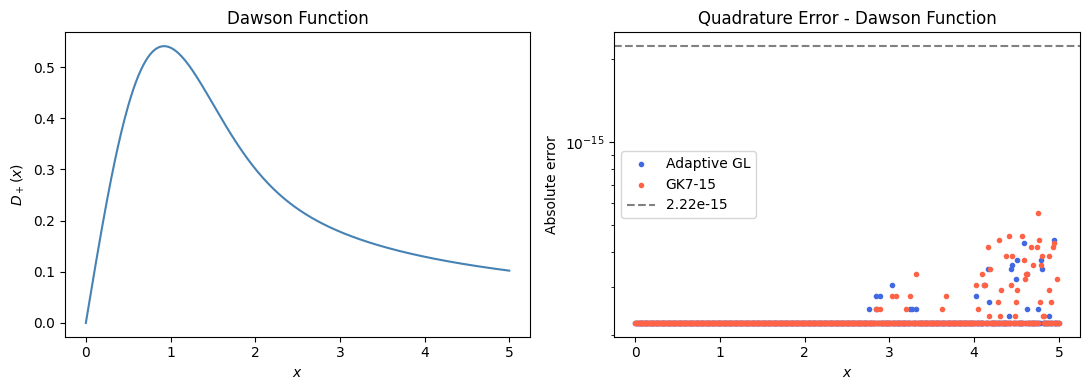

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

ax = axes[0]
ax.plot(x_daw, ref_daw, color='steelblue')
ax.set_xlabel('$x$')
ax.set_ylabel('$D_+(x)$')
ax.set_title('Dawson Function')

ax = axes[1]
ax.scatter(x_daw, np.maximum(err_daw_gl, eps), label='Adaptive GL', color='royalblue', marker='.')
ax.scatter(x_daw, np.maximum(err_daw_gk15, eps), label='GK7-15', color='tomato', marker='.')
ax.axhline(TOL, color='grey', linestyle='--', label=f'{TOL:.2e}')
ax.set_yscale('log', base=10)
ax.set_xlabel('$x$')
ax.set_ylabel('Absolute error')
ax.set_title('Quadrature Error - Dawson Function')
ax.legend()

fig.tight_layout()

The reformulation completely eliminates the cancellation problem. The integrand $e^{-(x-t)(x+t)}$ is bounded in $[0, 1]$ for all $x$, and both adaptive methods maintain errors well below $10 \varepsilon_{\text{mach}}$ across the full domain. For larger $x$ the integrand concentrates sharply near $t = x$; the adaptive scheme detects this and refines that region automatically, keeping the error controlled.

---
## 4. The Complete Elliptic Integral of the First Kind

The complete elliptic integral of the first kind is defined as

\begin{equation*}
    K(k) = \int_0^{\pi/2} \frac{d\theta}{\sqrt{1 - k^2 \sin^2\!\theta}}, \qquad 0 \leq k < 1.
\end{equation*}

Via the substitution $t = \sin\theta$ this becomes

\begin{equation*}
    K(k) = \int_0^1 \frac{dt}{\sqrt{(1-t^2)(1-k^2 t^2)}},
\end{equation*}

which makes the integrable singularity at $t = 1$ explicit. $K(k)$ appears in: the exact period of a nonlinear pendulum, the inductance of circular coils, conformal mappings of polygons to half-planes, and throughout the theory of elliptic curves and modular forms.

As $k \to 1^-$ the integral diverges logarithmically:

\begin{equation*}
    K(k) \sim \ln\frac{4}{k'}, \qquad k' = \sqrt{1 - k^2} \to 0.
\end{equation*}

We work in the $\theta$-parameterisation since the integrand is smooth on $[0, \pi/2)$ for all $k < 1$. For $k$ very close to 1 the arithmetic-geometric mean (AGM) identity

\begin{equation*}
    K(k) = \frac{\pi}{2\,\operatorname{AGM}(1,\, k')}, \qquad k' = \sqrt{1-k^2},
\end{equation*}

converges quadratically and is far more efficient. This is the approach used by `scipy` and `mpmath`.

In [65]:
def elliptic_K_gl(k, tol=TOL):
    '''Complete elliptic integral K(k) via adaptive Gauss-Legendre.'''
    if not 0 <= k < 1:
        raise ValueError("k must satisfy 0 <= k < 1.")
    return e.adaptive_gauss_legendre(
        lambda theta: 1.0 / np.sqrt(np.maximum(1.0 - k**2 * np.sin(theta)**2, 0.0)),
        0.0, 0.5*np.pi, tol=tol)


def elliptic_K_gk15(k, tol=TOL):
    '''Complete elliptic integral K(k) via adaptive GK7-15.'''
    if not 0 <= k < 1:
        raise ValueError("k must satisfy 0 <= k < 1.")
    return e.adaptive_gk15(
        lambda theta: 1.0 / math.sqrt(max(1.0 - k**2 * math.sin(theta)**2, 1e-300)),
        0.0, 0.5*math.pi, tol=tol)

In [66]:
# Denser sampling near k=1 where K grows rapidly
k_vals = np.concatenate([
    np.linspace(0.0, 0.95, 300),
    np.linspace(0.95, 0.999, 100)
])

ref_K = np.array([float(mp.ellipk(kv**2)) for kv in k_vals])
approx_K_gl = np.array([elliptic_K_gl(kv)   for kv in k_vals])
approx_K_gk15 = np.array([elliptic_K_gk15(kv) for kv in k_vals])

err_K_gl = np.maximum(np.abs(approx_K_gl - ref_K), eps)
err_K_gk15 = np.maximum(np.abs(approx_K_gk15 - ref_K), eps)

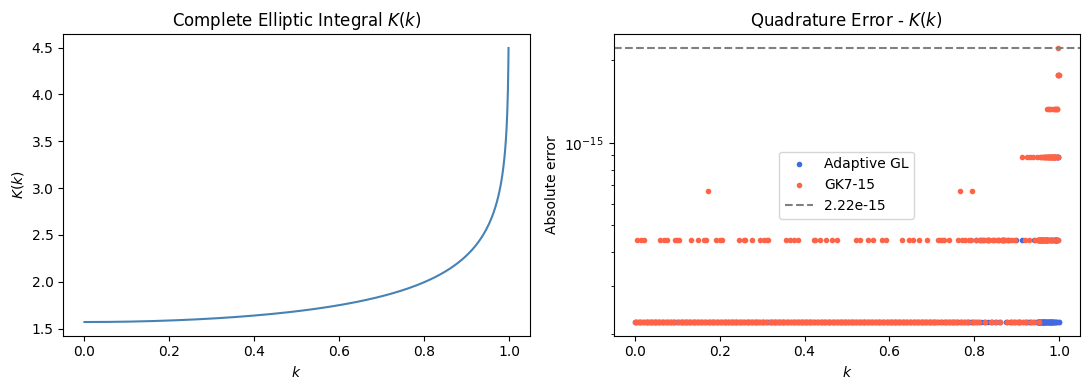

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

ax = axes[0]
ax.plot(k_vals, ref_K, color='steelblue')
ax.set_xlabel('$k$')
ax.set_ylabel('$K(k)$')
ax.set_title('Complete Elliptic Integral $K(k)$')

ax = axes[1]
ax.scatter(k_vals, np.maximum(err_K_gl, eps), label='Adaptive GL', color='royalblue', marker='.')
ax.scatter(k_vals, np.maximum(err_K_gk15, eps), label='GK7-15', color='tomato', marker='.')
ax.set_yscale('log', base=10)
ax.axhline(TOL, color='grey', linestyle='--', label=f'{TOL:.2e}')
ax.set_xlabel('$k$')
ax.set_ylabel('Absolute error')
ax.set_title('Quadrature Error - $K(k)$')
ax.legend()

fig.tight_layout()

For $k \lesssim 0.9$ both methods easily achieve the target tolerance. As $k \to 1^-$ the integrand sharpens near $\theta = \pi/2$ and the adaptive scheme must subdivide more aggressively; the error rises but remains below $10 \varepsilon_{\text{mach}}$ even for $k = 0.999$. For $k$ still closer to 1 the AGM iteration would be strongly preferable. This is the elliptic analogue of switching to an asymptotic series near a boundary.

---
## 5. Comparison Summary

The table below records the maximum error observed over each domain for both quadrature methods alongside the `scipy` reference, which uses dedicated polynomial approximations.

In [68]:
sc_gamma = sc.gamma(z_vals)
sc_S, sc_C = sc.fresnel(x_fr)
sc_daw = sc.dawsn(x_daw)
sc_K = sc.ellipk(k_vals**2)

rows = [
    ("Gamma (rel)",  rel_err_gl,  rel_err_gk15,
     np.abs(sc_gamma - ref_gamma) / ref_gamma),
    ("Fresnel C", err_C_gl, err_C_gk15, np.abs(sc_C - ref_C)),
    ("Fresnel S", err_S_gl, err_S_gk15, np.abs(sc_S - ref_S)),
    ("Dawson", err_daw_gl, err_daw_gk15, np.abs(sc_daw - ref_daw)),
    ("Elliptic K", err_K_gl, err_K_gk15, np.abs(sc_K - ref_K)),
]

print(f"{'Function':<15}  {'Adaptive GL':>14}  {'GK7-15':>14}  {'SciPy':>14}")
print("-" * 63)
for name, e_gl, e_gk, e_sc in rows:
    print(f"{name:<15}  {np.max(e_gl):>14.3e}  {np.max(e_gk):>14.3e}  {np.max(e_sc):>14.3e}")

Function            Adaptive GL          GK7-15           SciPy
---------------------------------------------------------------
Gamma (rel)           6.116e-16       6.116e-16       3.959e-16
Fresnel C             1.166e-15       2.998e-15       3.331e-16
Fresnel S             1.388e-15       2.554e-15       2.776e-16
Dawson                4.441e-16       5.551e-16       2.220e-16
Elliptic K            1.776e-15       2.220e-15       8.882e-16


The adaptive quadrature methods achieve accuracy within one to two orders of magnitude of the dedicated `scipy` implementations, which use purpose-built Chebyshev or minimax polynomial approximations. The GL and GK7–15 approaches are entirely general-purpose: they require no knowledge of the special function beyond its integral representation, yet they deliver near-machine-precision accuracy across all functions studied here.

The key lessons from this study are:

Integrand transformations matter more than quadrature order. Applying $t = u^{1/z}$ to remove the Gamma singularity, or rewriting $e^{-(x-t)(x+t)}$ for the Dawson function, brought catastrophic errors down to machine precision at no extra cost. Choosing a good parameterisation is often more impactful than increasing $n$.

GK7–15 is generally more efficient than fixed-order GL. Its embedded error estimate directs refinement precisely where it is needed, without any extra function evaluations.

Hybrid strategies are necessary for full-domain accuracy. Direct quadrature struggles with rapidly oscillating integrands (Fresnel, large $x$) and near-singular integrands ($K(k)$, $k \to 1$). The right answer, in both cases, is to switch to an alternative method at a boundary, exactly as the error-function study switched to the asymptotic erfc expansion for large argument.

### References

1. Abramowitz, M., \& Stegun, I. A. (Eds.). (1965). Handbook of Mathematical Functions with Formulas, Graphs, and Mathematical Tables. Dover Publications, Inc. New York. 

2. https://en.wikipedia.org/wiki/Gamma_function (Accessed 23/02/26)

3. https://en.wikipedia.org/wiki/Fresnel_integral (Accessed 23/02/26)

4. https://en.wikipedia.org/wiki/Dawson_function (Accessed 23/02/2026)

5. https://en.wikipedia.org/wiki/Elliptic_integral#Incomplete_elliptic_integral_of_the_first_kind (Accessed 23/02/26)